# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [75]:
data_dir = '/'
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

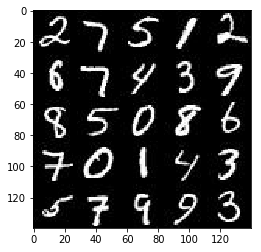

In [76]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

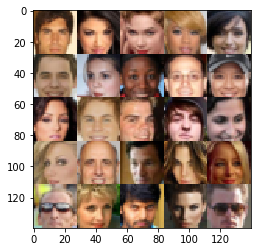

In [77]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [79]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(tf.float32, shape=())
    return images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [80]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [81]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        # using valid padding and stride 1 to get size of 7 instead of 8
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [82]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [83]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [85]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if batch_i % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, batch {}...".format(epoch_i + 1, epoch_count, batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if batch_i % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, batch 0... Discriminator Loss: 11.9513... Generator Loss: 0.0000


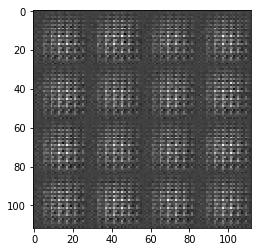

Epoch 1/2, batch 10... Discriminator Loss: 0.5942... Generator Loss: 5.3482
Epoch 1/2, batch 20... Discriminator Loss: 1.2064... Generator Loss: 0.7501
Epoch 1/2, batch 30... Discriminator Loss: 0.9756... Generator Loss: 1.1190
Epoch 1/2, batch 40... Discriminator Loss: 2.0384... Generator Loss: 0.4531
Epoch 1/2, batch 50... Discriminator Loss: 1.0677... Generator Loss: 0.7753
Epoch 1/2, batch 60... Discriminator Loss: 1.8390... Generator Loss: 0.4973
Epoch 1/2, batch 70... Discriminator Loss: 1.3838... Generator Loss: 0.8784
Epoch 1/2, batch 80... Discriminator Loss: 1.2870... Generator Loss: 0.7662
Epoch 1/2, batch 90... Discriminator Loss: 1.6793... Generator Loss: 0.5161
Epoch 1/2, batch 100... Discriminator Loss: 1.4563... Generator Loss: 0.5983


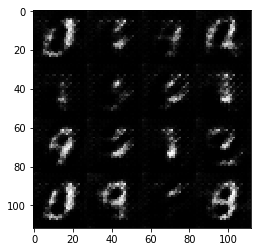

Epoch 1/2, batch 110... Discriminator Loss: 1.3198... Generator Loss: 0.9808
Epoch 1/2, batch 120... Discriminator Loss: 1.2168... Generator Loss: 0.9590
Epoch 1/2, batch 130... Discriminator Loss: 1.3662... Generator Loss: 1.0483
Epoch 1/2, batch 140... Discriminator Loss: 1.3415... Generator Loss: 0.7716
Epoch 1/2, batch 150... Discriminator Loss: 1.5402... Generator Loss: 0.7918
Epoch 1/2, batch 160... Discriminator Loss: 1.5642... Generator Loss: 1.3500
Epoch 1/2, batch 170... Discriminator Loss: 1.3976... Generator Loss: 0.6324
Epoch 1/2, batch 180... Discriminator Loss: 1.7059... Generator Loss: 0.3882
Epoch 1/2, batch 190... Discriminator Loss: 1.4339... Generator Loss: 0.9104
Epoch 1/2, batch 200... Discriminator Loss: 1.5427... Generator Loss: 0.5350


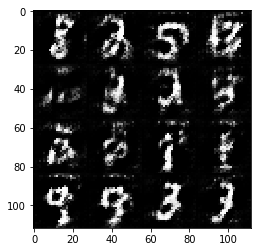

Epoch 1/2, batch 210... Discriminator Loss: 1.4194... Generator Loss: 0.5521
Epoch 1/2, batch 220... Discriminator Loss: 1.5499... Generator Loss: 0.4018
Epoch 1/2, batch 230... Discriminator Loss: 1.4591... Generator Loss: 0.5465
Epoch 1/2, batch 240... Discriminator Loss: 1.5482... Generator Loss: 0.7135
Epoch 1/2, batch 250... Discriminator Loss: 1.5352... Generator Loss: 0.9809
Epoch 1/2, batch 260... Discriminator Loss: 1.3900... Generator Loss: 0.6846
Epoch 1/2, batch 270... Discriminator Loss: 1.3297... Generator Loss: 0.5040
Epoch 1/2, batch 280... Discriminator Loss: 1.6468... Generator Loss: 0.3302
Epoch 1/2, batch 290... Discriminator Loss: 1.4181... Generator Loss: 0.9571
Epoch 1/2, batch 300... Discriminator Loss: 1.3138... Generator Loss: 0.8506


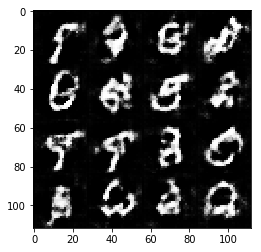

Epoch 1/2, batch 310... Discriminator Loss: 1.5828... Generator Loss: 1.3907
Epoch 1/2, batch 320... Discriminator Loss: 1.3936... Generator Loss: 0.8610
Epoch 1/2, batch 330... Discriminator Loss: 1.3131... Generator Loss: 0.9493
Epoch 1/2, batch 340... Discriminator Loss: 1.3892... Generator Loss: 0.8025
Epoch 1/2, batch 350... Discriminator Loss: 1.5143... Generator Loss: 1.1478
Epoch 1/2, batch 360... Discriminator Loss: 1.4248... Generator Loss: 0.7715
Epoch 1/2, batch 370... Discriminator Loss: 1.4619... Generator Loss: 0.4575
Epoch 1/2, batch 380... Discriminator Loss: 1.3714... Generator Loss: 1.0521
Epoch 1/2, batch 390... Discriminator Loss: 1.4258... Generator Loss: 1.0391
Epoch 1/2, batch 400... Discriminator Loss: 1.3583... Generator Loss: 0.5616


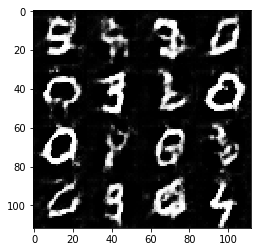

Epoch 1/2, batch 410... Discriminator Loss: 1.3499... Generator Loss: 0.5885
Epoch 1/2, batch 420... Discriminator Loss: 1.4940... Generator Loss: 0.4077
Epoch 1/2, batch 430... Discriminator Loss: 1.4029... Generator Loss: 0.5805
Epoch 1/2, batch 440... Discriminator Loss: 1.4199... Generator Loss: 0.9213
Epoch 1/2, batch 450... Discriminator Loss: 1.3657... Generator Loss: 0.7132
Epoch 1/2, batch 460... Discriminator Loss: 1.3809... Generator Loss: 0.8400
Epoch 2/2, batch 0... Discriminator Loss: 1.5196... Generator Loss: 1.1026


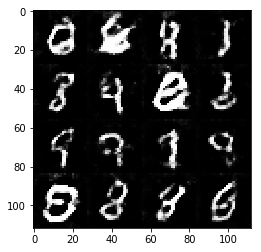

Epoch 2/2, batch 10... Discriminator Loss: 1.4328... Generator Loss: 0.9243
Epoch 2/2, batch 20... Discriminator Loss: 1.2498... Generator Loss: 0.6964
Epoch 2/2, batch 30... Discriminator Loss: 1.3394... Generator Loss: 0.9177
Epoch 2/2, batch 40... Discriminator Loss: 1.3256... Generator Loss: 0.8598
Epoch 2/2, batch 50... Discriminator Loss: 1.3899... Generator Loss: 0.4612
Epoch 2/2, batch 60... Discriminator Loss: 1.3575... Generator Loss: 0.6884
Epoch 2/2, batch 70... Discriminator Loss: 1.3538... Generator Loss: 0.6179
Epoch 2/2, batch 80... Discriminator Loss: 1.3456... Generator Loss: 0.5999
Epoch 2/2, batch 90... Discriminator Loss: 1.4134... Generator Loss: 0.4596
Epoch 2/2, batch 100... Discriminator Loss: 1.3553... Generator Loss: 0.7266


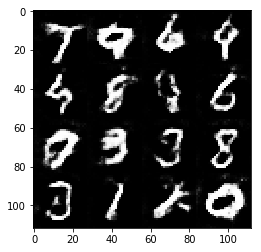

Epoch 2/2, batch 110... Discriminator Loss: 1.3827... Generator Loss: 0.8591
Epoch 2/2, batch 120... Discriminator Loss: 1.7271... Generator Loss: 0.2532
Epoch 2/2, batch 130... Discriminator Loss: 1.4042... Generator Loss: 0.5842
Epoch 2/2, batch 140... Discriminator Loss: 1.4934... Generator Loss: 0.4111
Epoch 2/2, batch 150... Discriminator Loss: 1.2427... Generator Loss: 0.8103
Epoch 2/2, batch 160... Discriminator Loss: 1.2610... Generator Loss: 0.6719
Epoch 2/2, batch 170... Discriminator Loss: 1.4400... Generator Loss: 0.4140
Epoch 2/2, batch 180... Discriminator Loss: 1.5065... Generator Loss: 0.3945
Epoch 2/2, batch 190... Discriminator Loss: 1.2970... Generator Loss: 0.8293
Epoch 2/2, batch 200... Discriminator Loss: 1.3788... Generator Loss: 0.9596


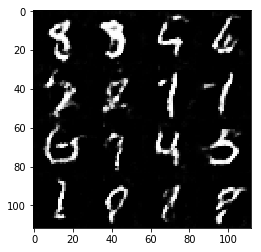

Epoch 2/2, batch 210... Discriminator Loss: 1.4903... Generator Loss: 0.4089
Epoch 2/2, batch 220... Discriminator Loss: 1.2586... Generator Loss: 0.6522
Epoch 2/2, batch 230... Discriminator Loss: 1.3658... Generator Loss: 0.5096
Epoch 2/2, batch 240... Discriminator Loss: 1.3096... Generator Loss: 0.4922
Epoch 2/2, batch 250... Discriminator Loss: 1.6477... Generator Loss: 0.2803
Epoch 2/2, batch 260... Discriminator Loss: 1.2896... Generator Loss: 0.6769
Epoch 2/2, batch 270... Discriminator Loss: 1.3286... Generator Loss: 0.7194
Epoch 2/2, batch 280... Discriminator Loss: 1.3475... Generator Loss: 0.5251
Epoch 2/2, batch 290... Discriminator Loss: 1.4727... Generator Loss: 1.1989
Epoch 2/2, batch 300... Discriminator Loss: 1.3012... Generator Loss: 0.6520


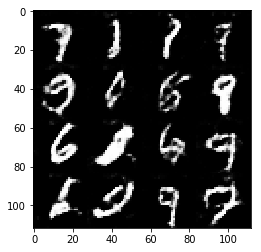

Epoch 2/2, batch 310... Discriminator Loss: 1.2795... Generator Loss: 0.6205
Epoch 2/2, batch 320... Discriminator Loss: 1.3602... Generator Loss: 0.4885
Epoch 2/2, batch 330... Discriminator Loss: 1.2511... Generator Loss: 0.6487
Epoch 2/2, batch 340... Discriminator Loss: 1.7762... Generator Loss: 1.1252
Epoch 2/2, batch 350... Discriminator Loss: 1.2682... Generator Loss: 0.6831
Epoch 2/2, batch 360... Discriminator Loss: 1.2764... Generator Loss: 0.6435
Epoch 2/2, batch 370... Discriminator Loss: 1.3629... Generator Loss: 0.7080
Epoch 2/2, batch 380... Discriminator Loss: 1.2943... Generator Loss: 0.7808
Epoch 2/2, batch 390... Discriminator Loss: 1.2683... Generator Loss: 0.6044
Epoch 2/2, batch 400... Discriminator Loss: 1.2465... Generator Loss: 0.7852


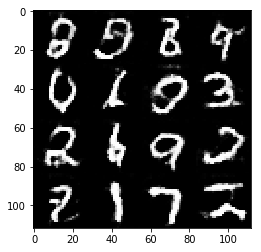

Epoch 2/2, batch 410... Discriminator Loss: 1.7424... Generator Loss: 1.4633
Epoch 2/2, batch 420... Discriminator Loss: 1.2913... Generator Loss: 0.5920
Epoch 2/2, batch 430... Discriminator Loss: 1.3661... Generator Loss: 0.5359
Epoch 2/2, batch 440... Discriminator Loss: 2.0366... Generator Loss: 0.1768
Epoch 2/2, batch 450... Discriminator Loss: 1.2042... Generator Loss: 0.6613
Epoch 2/2, batch 460... Discriminator Loss: 1.2478... Generator Loss: 0.7415


In [86]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, batch 0... Discriminator Loss: 10.5436... Generator Loss: 0.0000


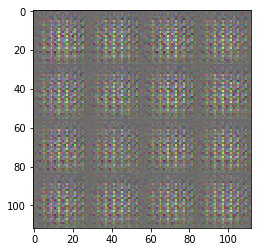

Epoch 1/1, batch 10... Discriminator Loss: 2.5192... Generator Loss: 1.2125
Epoch 1/1, batch 20... Discriminator Loss: 1.4738... Generator Loss: 1.5806
Epoch 1/1, batch 30... Discriminator Loss: 4.2908... Generator Loss: 0.0355
Epoch 1/1, batch 40... Discriminator Loss: 1.5222... Generator Loss: 2.1084
Epoch 1/1, batch 50... Discriminator Loss: 1.2712... Generator Loss: 0.8029
Epoch 1/1, batch 60... Discriminator Loss: 0.9769... Generator Loss: 1.7902
Epoch 1/1, batch 70... Discriminator Loss: 1.3101... Generator Loss: 0.7666
Epoch 1/1, batch 80... Discriminator Loss: 1.6005... Generator Loss: 0.7059
Epoch 1/1, batch 90... Discriminator Loss: 1.4337... Generator Loss: 0.8073
Epoch 1/1, batch 100... Discriminator Loss: 2.7622... Generator Loss: 0.3938


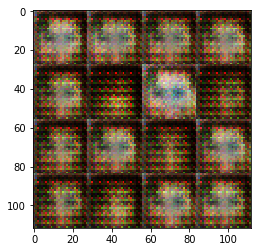

Epoch 1/1, batch 110... Discriminator Loss: 2.1245... Generator Loss: 0.4917
Epoch 1/1, batch 120... Discriminator Loss: 2.0871... Generator Loss: 0.4076
Epoch 1/1, batch 130... Discriminator Loss: 1.6768... Generator Loss: 0.6615
Epoch 1/1, batch 140... Discriminator Loss: 1.4296... Generator Loss: 0.8689
Epoch 1/1, batch 150... Discriminator Loss: 1.9195... Generator Loss: 0.6655
Epoch 1/1, batch 160... Discriminator Loss: 1.4064... Generator Loss: 0.7041
Epoch 1/1, batch 170... Discriminator Loss: 1.2093... Generator Loss: 0.7931
Epoch 1/1, batch 180... Discriminator Loss: 1.6781... Generator Loss: 0.6490
Epoch 1/1, batch 190... Discriminator Loss: 1.8149... Generator Loss: 0.5092
Epoch 1/1, batch 200... Discriminator Loss: 1.5721... Generator Loss: 0.5920


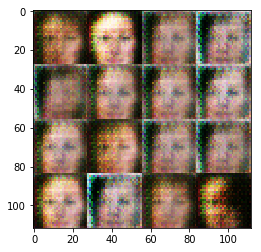

Epoch 1/1, batch 210... Discriminator Loss: 1.6664... Generator Loss: 0.5586
Epoch 1/1, batch 220... Discriminator Loss: 1.6608... Generator Loss: 0.6026
Epoch 1/1, batch 230... Discriminator Loss: 1.7342... Generator Loss: 0.6280
Epoch 1/1, batch 240... Discriminator Loss: 1.7361... Generator Loss: 0.6186
Epoch 1/1, batch 250... Discriminator Loss: 1.4978... Generator Loss: 0.6482
Epoch 1/1, batch 260... Discriminator Loss: 1.6599... Generator Loss: 0.6037
Epoch 1/1, batch 270... Discriminator Loss: 1.8305... Generator Loss: 0.5270
Epoch 1/1, batch 280... Discriminator Loss: 1.5681... Generator Loss: 0.6211
Epoch 1/1, batch 290... Discriminator Loss: 1.6194... Generator Loss: 0.6482
Epoch 1/1, batch 300... Discriminator Loss: 1.3024... Generator Loss: 0.7132


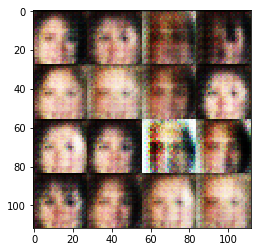

Epoch 1/1, batch 310... Discriminator Loss: 1.5193... Generator Loss: 0.6668
Epoch 1/1, batch 320... Discriminator Loss: 1.5566... Generator Loss: 0.6222
Epoch 1/1, batch 330... Discriminator Loss: 1.5137... Generator Loss: 0.6499
Epoch 1/1, batch 340... Discriminator Loss: 1.4602... Generator Loss: 0.6891
Epoch 1/1, batch 350... Discriminator Loss: 1.6359... Generator Loss: 0.5587
Epoch 1/1, batch 360... Discriminator Loss: 1.3879... Generator Loss: 0.6938
Epoch 1/1, batch 370... Discriminator Loss: 1.5659... Generator Loss: 0.6374
Epoch 1/1, batch 380... Discriminator Loss: 1.6563... Generator Loss: 0.6150
Epoch 1/1, batch 390... Discriminator Loss: 1.6037... Generator Loss: 0.6135
Epoch 1/1, batch 400... Discriminator Loss: 1.3485... Generator Loss: 0.7367


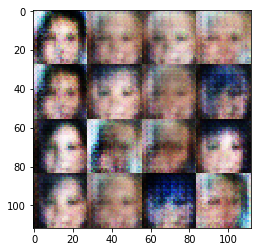

Epoch 1/1, batch 410... Discriminator Loss: 1.6129... Generator Loss: 0.6366
Epoch 1/1, batch 420... Discriminator Loss: 1.6517... Generator Loss: 0.5617
Epoch 1/1, batch 430... Discriminator Loss: 1.4008... Generator Loss: 0.7184
Epoch 1/1, batch 440... Discriminator Loss: 1.6058... Generator Loss: 0.6020
Epoch 1/1, batch 450... Discriminator Loss: 1.4082... Generator Loss: 0.6688
Epoch 1/1, batch 460... Discriminator Loss: 1.4636... Generator Loss: 0.7243
Epoch 1/1, batch 470... Discriminator Loss: 1.6772... Generator Loss: 0.5996
Epoch 1/1, batch 480... Discriminator Loss: 1.4379... Generator Loss: 0.6185
Epoch 1/1, batch 490... Discriminator Loss: 1.4042... Generator Loss: 0.7173
Epoch 1/1, batch 500... Discriminator Loss: 1.4716... Generator Loss: 0.6988


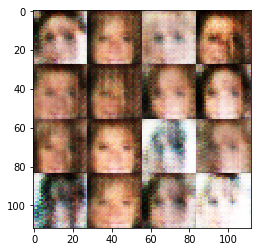

Epoch 1/1, batch 510... Discriminator Loss: 1.4483... Generator Loss: 0.6727
Epoch 1/1, batch 520... Discriminator Loss: 1.4510... Generator Loss: 0.6758
Epoch 1/1, batch 530... Discriminator Loss: 1.5107... Generator Loss: 0.6704
Epoch 1/1, batch 540... Discriminator Loss: 1.4295... Generator Loss: 0.6470
Epoch 1/1, batch 550... Discriminator Loss: 1.4917... Generator Loss: 0.6161
Epoch 1/1, batch 560... Discriminator Loss: 1.4550... Generator Loss: 0.6723
Epoch 1/1, batch 570... Discriminator Loss: 1.3830... Generator Loss: 0.6800
Epoch 1/1, batch 580... Discriminator Loss: 1.4563... Generator Loss: 0.6807
Epoch 1/1, batch 590... Discriminator Loss: 1.5563... Generator Loss: 0.6550
Epoch 1/1, batch 600... Discriminator Loss: 1.5157... Generator Loss: 0.5993


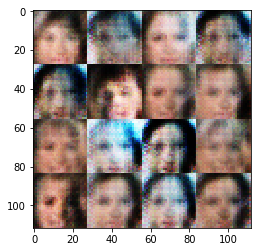

Epoch 1/1, batch 610... Discriminator Loss: 1.4343... Generator Loss: 0.6590
Epoch 1/1, batch 620... Discriminator Loss: 1.4035... Generator Loss: 0.7210
Epoch 1/1, batch 630... Discriminator Loss: 1.4640... Generator Loss: 0.7500
Epoch 1/1, batch 640... Discriminator Loss: 1.5332... Generator Loss: 0.6122
Epoch 1/1, batch 650... Discriminator Loss: 1.5073... Generator Loss: 0.6320
Epoch 1/1, batch 660... Discriminator Loss: 1.3376... Generator Loss: 0.7189
Epoch 1/1, batch 670... Discriminator Loss: 1.5273... Generator Loss: 0.6573
Epoch 1/1, batch 680... Discriminator Loss: 1.4098... Generator Loss: 0.7009
Epoch 1/1, batch 690... Discriminator Loss: 1.5365... Generator Loss: 0.6719
Epoch 1/1, batch 700... Discriminator Loss: 1.4681... Generator Loss: 0.6654


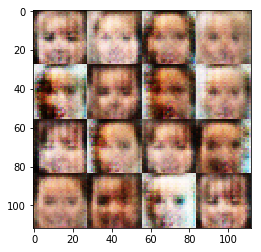

Epoch 1/1, batch 710... Discriminator Loss: 1.4547... Generator Loss: 0.6646
Epoch 1/1, batch 720... Discriminator Loss: 1.5032... Generator Loss: 0.6290
Epoch 1/1, batch 730... Discriminator Loss: 1.4186... Generator Loss: 0.6782
Epoch 1/1, batch 740... Discriminator Loss: 1.4932... Generator Loss: 0.6344
Epoch 1/1, batch 750... Discriminator Loss: 1.4241... Generator Loss: 0.6864
Epoch 1/1, batch 760... Discriminator Loss: 1.3879... Generator Loss: 0.7268
Epoch 1/1, batch 770... Discriminator Loss: 1.5055... Generator Loss: 0.6746
Epoch 1/1, batch 780... Discriminator Loss: 1.4433... Generator Loss: 0.6447
Epoch 1/1, batch 790... Discriminator Loss: 1.4590... Generator Loss: 0.6377
Epoch 1/1, batch 800... Discriminator Loss: 1.4067... Generator Loss: 0.6908


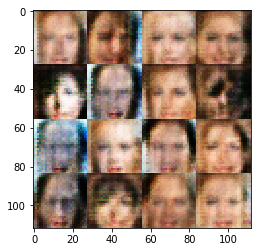

Epoch 1/1, batch 810... Discriminator Loss: 1.4537... Generator Loss: 0.6727
Epoch 1/1, batch 820... Discriminator Loss: 1.4648... Generator Loss: 0.6683
Epoch 1/1, batch 830... Discriminator Loss: 1.4436... Generator Loss: 0.6467
Epoch 1/1, batch 840... Discriminator Loss: 1.4124... Generator Loss: 0.6822
Epoch 1/1, batch 850... Discriminator Loss: 1.4727... Generator Loss: 0.6586
Epoch 1/1, batch 860... Discriminator Loss: 1.5101... Generator Loss: 0.7004
Epoch 1/1, batch 870... Discriminator Loss: 1.4269... Generator Loss: 0.6380
Epoch 1/1, batch 880... Discriminator Loss: 1.4965... Generator Loss: 0.6838
Epoch 1/1, batch 890... Discriminator Loss: 1.3813... Generator Loss: 0.7154
Epoch 1/1, batch 900... Discriminator Loss: 1.5575... Generator Loss: 0.5899


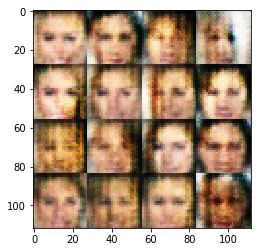

Epoch 1/1, batch 910... Discriminator Loss: 1.4658... Generator Loss: 0.6911
Epoch 1/1, batch 920... Discriminator Loss: 1.4133... Generator Loss: 0.6881
Epoch 1/1, batch 930... Discriminator Loss: 1.4236... Generator Loss: 0.6916
Epoch 1/1, batch 940... Discriminator Loss: 1.4973... Generator Loss: 0.6324
Epoch 1/1, batch 950... Discriminator Loss: 1.4080... Generator Loss: 0.7071
Epoch 1/1, batch 960... Discriminator Loss: 1.4446... Generator Loss: 0.6290
Epoch 1/1, batch 970... Discriminator Loss: 1.4700... Generator Loss: 0.6446
Epoch 1/1, batch 980... Discriminator Loss: 1.4845... Generator Loss: 0.6800
Epoch 1/1, batch 990... Discriminator Loss: 1.4147... Generator Loss: 0.6115
Epoch 1/1, batch 1000... Discriminator Loss: 1.4656... Generator Loss: 0.6322


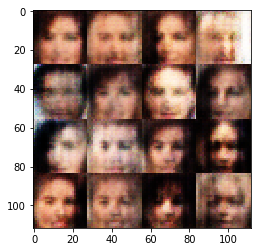

Epoch 1/1, batch 1010... Discriminator Loss: 1.4754... Generator Loss: 0.6638
Epoch 1/1, batch 1020... Discriminator Loss: 1.4266... Generator Loss: 0.6404
Epoch 1/1, batch 1030... Discriminator Loss: 1.5038... Generator Loss: 0.6475
Epoch 1/1, batch 1040... Discriminator Loss: 1.5219... Generator Loss: 0.5838
Epoch 1/1, batch 1050... Discriminator Loss: 1.4054... Generator Loss: 0.7983
Epoch 1/1, batch 1060... Discriminator Loss: 1.4485... Generator Loss: 0.6424
Epoch 1/1, batch 1070... Discriminator Loss: 1.4286... Generator Loss: 0.7431
Epoch 1/1, batch 1080... Discriminator Loss: 1.4652... Generator Loss: 0.6461
Epoch 1/1, batch 1090... Discriminator Loss: 1.5103... Generator Loss: 0.6817
Epoch 1/1, batch 1100... Discriminator Loss: 1.4343... Generator Loss: 0.6545


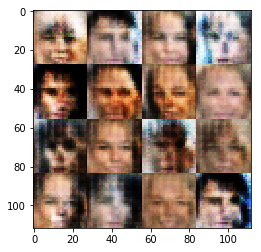

Epoch 1/1, batch 1110... Discriminator Loss: 1.4220... Generator Loss: 0.6758
Epoch 1/1, batch 1120... Discriminator Loss: 1.4647... Generator Loss: 0.6228
Epoch 1/1, batch 1130... Discriminator Loss: 1.4695... Generator Loss: 0.6620
Epoch 1/1, batch 1140... Discriminator Loss: 1.3873... Generator Loss: 0.6784
Epoch 1/1, batch 1150... Discriminator Loss: 1.4656... Generator Loss: 0.6455
Epoch 1/1, batch 1160... Discriminator Loss: 1.5094... Generator Loss: 0.5890
Epoch 1/1, batch 1170... Discriminator Loss: 1.4697... Generator Loss: 0.6971
Epoch 1/1, batch 1180... Discriminator Loss: 1.4625... Generator Loss: 0.7181
Epoch 1/1, batch 1190... Discriminator Loss: 1.4847... Generator Loss: 0.6534
Epoch 1/1, batch 1200... Discriminator Loss: 1.4303... Generator Loss: 0.7200


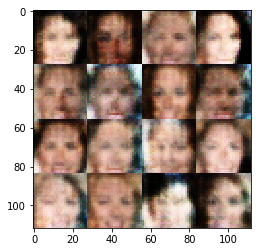

Epoch 1/1, batch 1210... Discriminator Loss: 1.4813... Generator Loss: 0.6867
Epoch 1/1, batch 1220... Discriminator Loss: 1.5134... Generator Loss: 0.6779
Epoch 1/1, batch 1230... Discriminator Loss: 1.5701... Generator Loss: 0.6503
Epoch 1/1, batch 1240... Discriminator Loss: 1.4281... Generator Loss: 0.6398
Epoch 1/1, batch 1250... Discriminator Loss: 1.4711... Generator Loss: 0.6413
Epoch 1/1, batch 1260... Discriminator Loss: 1.4626... Generator Loss: 0.5990
Epoch 1/1, batch 1270... Discriminator Loss: 1.4305... Generator Loss: 0.6562
Epoch 1/1, batch 1280... Discriminator Loss: 1.4674... Generator Loss: 0.6459
Epoch 1/1, batch 1290... Discriminator Loss: 1.4191... Generator Loss: 0.6490
Epoch 1/1, batch 1300... Discriminator Loss: 1.4653... Generator Loss: 0.6920


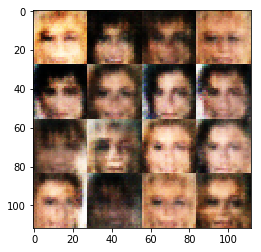

Epoch 1/1, batch 1310... Discriminator Loss: 1.4450... Generator Loss: 0.6667
Epoch 1/1, batch 1320... Discriminator Loss: 1.4870... Generator Loss: 0.6361
Epoch 1/1, batch 1330... Discriminator Loss: 1.4536... Generator Loss: 0.6596
Epoch 1/1, batch 1340... Discriminator Loss: 1.4575... Generator Loss: 0.6541
Epoch 1/1, batch 1350... Discriminator Loss: 1.3990... Generator Loss: 0.6865
Epoch 1/1, batch 1360... Discriminator Loss: 1.4640... Generator Loss: 0.6886
Epoch 1/1, batch 1370... Discriminator Loss: 1.3834... Generator Loss: 0.6546
Epoch 1/1, batch 1380... Discriminator Loss: 1.4718... Generator Loss: 0.6314
Epoch 1/1, batch 1390... Discriminator Loss: 1.4024... Generator Loss: 0.6623
Epoch 1/1, batch 1400... Discriminator Loss: 1.4591... Generator Loss: 0.6532


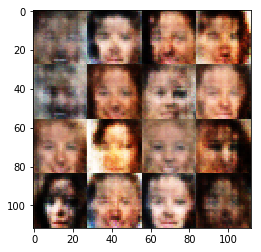

Epoch 1/1, batch 1410... Discriminator Loss: 1.4633... Generator Loss: 0.7133
Epoch 1/1, batch 1420... Discriminator Loss: 1.4393... Generator Loss: 0.6313
Epoch 1/1, batch 1430... Discriminator Loss: 1.4764... Generator Loss: 0.6455
Epoch 1/1, batch 1440... Discriminator Loss: 1.3966... Generator Loss: 0.6788
Epoch 1/1, batch 1450... Discriminator Loss: 1.4673... Generator Loss: 0.6946
Epoch 1/1, batch 1460... Discriminator Loss: 1.4223... Generator Loss: 0.7043
Epoch 1/1, batch 1470... Discriminator Loss: 1.4487... Generator Loss: 0.6797
Epoch 1/1, batch 1480... Discriminator Loss: 1.4232... Generator Loss: 0.6606
Epoch 1/1, batch 1490... Discriminator Loss: 1.4593... Generator Loss: 0.6589
Epoch 1/1, batch 1500... Discriminator Loss: 1.4279... Generator Loss: 0.6834


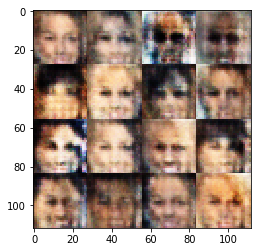

Epoch 1/1, batch 1510... Discriminator Loss: 1.4096... Generator Loss: 0.6416
Epoch 1/1, batch 1520... Discriminator Loss: 1.4473... Generator Loss: 0.7104
Epoch 1/1, batch 1530... Discriminator Loss: 1.4736... Generator Loss: 0.6424
Epoch 1/1, batch 1540... Discriminator Loss: 1.4120... Generator Loss: 0.6924
Epoch 1/1, batch 1550... Discriminator Loss: 1.4679... Generator Loss: 0.6723
Epoch 1/1, batch 1560... Discriminator Loss: 1.4036... Generator Loss: 0.7582
Epoch 1/1, batch 1570... Discriminator Loss: 1.4996... Generator Loss: 0.6588
Epoch 1/1, batch 1580... Discriminator Loss: 1.4584... Generator Loss: 0.6613


In [88]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.